In [28]:
import json
import os
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from network import Network, Node, Road, Lane

In [29]:
network = Network()
network.create_network(3,2,200,25)

# not_considered_roads_changed_network = [26,25,27,28,29,30,31,32,33,34,39,40,41,42,44,43,48,47,45,46,3,14,22,12,2,4,13,35]
not_considered_roads_changed_network = [26,25,27,28,31,32,33,34,39,40,41,42,48,47,45,46,3,14,22,12,2]

Grid built with 21 nodes, 48 roads.


In [30]:
def is_car(jid):
    return jid.startswith("car")

def is_tl(jid):
    return jid.startswith("tl")

def tl_id(jid):
    return int(jid.split("@")[0].replace("tl", ""))

def summarize_single_simulation(sim_data, filename):
    cars = {}
    tls = {}

    for jid, info in sim_data.items():

        if not isinstance(info, dict):
            continue  # skip metadata fields

        if is_car(jid):
            cars[jid] = info

        if "notChangedNetwork" in filename:
            if is_tl(jid) and (tl_id(jid) <= 24) and len(info["n_leaving_cars_per_cycle"]) > 0 and sum(info["n_leaving_cars_per_cycle"]) > 0:
                tls[jid] = info
        else:
            if is_tl(jid) and (tl_id(jid) <= 24) and (tl_id(jid) not in not_considered_roads_changed_network) and len(info["n_leaving_cars_per_cycle"]) > 0 and sum(info["n_leaving_cars_per_cycle"]) > 0:
                tls[jid] = info

    # -----------------------------
    # CAR SUMMARY
    # -----------------------------
    if cars:
        car_summary = {
            "n_cars": len(cars),
            "sum_travel_time": sum(c["travel_time"] for c in cars.values()),
            "min_travel_time": min(c["travel_time"] for c in cars.values()),
            "max_travel_time": max(c["travel_time"] for c in cars.values()),
            "sum_total_distance": sum(c["total_distance"] for c in cars.values()),
            "sum_free_flow_time": sum(sum(c["free_flow_time"]) for c in cars.values()),
            "sum_waiting_at_lights": sum(sum(c["time_stopped_at_traffic_lights"]) for c in cars.values()),
            "sum_waiting_behind_cars": sum(sum(c["waiting_behind_other_cars_time"]) for c in cars.values()),
        }
    else:
        car_summary = {}

    # -----------------------------
    # TRAFFIC LIGHT SUMMARY
    # -----------------------------
    if tls:
        tl_summary = {
            "n_active_traffic_lights": len(tls),
            "avg_number_of_cycles": mean(len(t["n_leaving_cars_per_cycle"]) for t in tls.values()),
            "avg_leaving_cars_per_cycle": mean(mean(t["n_leaving_cars_per_cycle"]) for t in tls.values()),
            "avg_queue_pressure": mean(mean(sum(q) for q in t["queue_length_per_cycle"]) for t in tls.values()),
            "sum_tolerance_built_up": sum(sum(t["tolerance_built_up"]) for t in tls.values()),
            "total_time_lost": sum(t["total_time_lost"] for t in tls.values()),
            "green_light_utilization_per_tl_per_cycle": {},
            "global_green_light_utilization": round(sum(t["n_leaving_cars_per_cycle"][i] for tl_key, t in tls.items() for i in range(min(len(t["n_leaving_cars_per_cycle"]), len(t["total_green_time_per_cycle"])))) / sum(max(1, int(t["total_green_time_per_cycle"][i] / 0.1)) for tl_key, t in tls.items() for i in range(min(len(t["n_leaving_cars_per_cycle"]),len(t["total_green_time_per_cycle"])))), 2)
        }

        for tl_jid, tl in tls.items():
            valid_len = min(
                len(tl["n_leaving_cars_per_cycle"]),
                len(tl["total_green_time_per_cycle"])
            )
            tl_summary["green_light_utilization_per_tl_per_cycle"][tl_jid] = [
                    round(tl["n_leaving_cars_per_cycle"][i] /
                    max(1, int(tl["total_green_time_per_cycle"][i] / 0.1)), 2)
                    for i in range(valid_len)]
    else:
        tl_summary = {}

    return {
        "car_summary": car_summary,
        "traffic_light_summary": tl_summary,
        "total_simulation_duration": sim_data["total_simulation_duration"] 
    }

In [31]:
# RESULTS_FOLDER = "simulation_results/travel_w_capacity_w_data"
# SUMMARY_FOLDER = "simulation_results/travel_w_capacity_w_data/summaries"
RESULTS_FOLDER = "simulation_results"
SUMMARY_FOLDER = "simulation_results/summaries"
os.makedirs(SUMMARY_FOLDER, exist_ok=True)

for filename in os.listdir(RESULTS_FOLDER):
    if not filename.endswith(".json") or "summary" in filename:
        continue
    
    input_path = os.path.join(RESULTS_FOLDER, filename)

    with open(input_path, "r") as f:
        sim_data = json.load(f)

    summary = summarize_single_simulation(sim_data, filename)

    # Output summary file name
    out_name = filename.replace(".json", "_summary.json")
    out_path = os.path.join(SUMMARY_FOLDER, out_name)

    with open(out_path, "w") as f:
        json.dump(summary, f, indent=4)

    print(f"Created summary → {out_name}")

Created summary → sim_travel0.1_capacity0.9_cyclic_adaptiveGreenTrue_changedNetwork_summary.json
Created summary → sim_travel0.1_capacity0.9_cyclic_adaptiveGreenTrue_notChangedNetwork_summary.json
Created summary → sim_travel0.1_capacity0.9_proposals_adaptiveGreenTrue_changedNetwork_summary.json
Created summary → sim_travel0.9_capacity0.1_cyclic_adaptiveGreenFalse_changedNetwork_summary.json
Created summary → sim_travel0.9_capacity0.1_cyclic_adaptiveGreenTrue_changedNetwork_summary.json
Created summary → sim_travel0.9_capacity0.1_cyclic_adaptiveGreenTrue_notChangedNetwork_summary.json
Created summary → sim_travel0.9_capacity0.1_proposals_adaptiveGreenFalse_changedNetwork_summary.json
Created summary → sim_travel0.9_capacity0.1_proposals_adaptiveGreenTrue_changedNetwork_summary.json


In [32]:
summary_dictionary = {}

for travel_capacity_comb in ["travel0.1_capacity0.9", "travel0.9_capacity0.1"]:
    summary_dictionary[travel_capacity_comb] = {}

    for type_of_tl in ["cyclic", "proposals"]:
        summary_dictionary[travel_capacity_comb][type_of_tl] = {}

        for network_type in ["notChangedNetwork", "changedNetwork"]:
            summary_dictionary[travel_capacity_comb][type_of_tl][network_type] = {}

            for adaptive_green in ["adaptiveGreenTrue", "adaptiveGreenFalse"]:
                summary_dictionary[travel_capacity_comb][type_of_tl][network_type][adaptive_green] = {}

                # look for the correct file
                for filename in os.listdir(SUMMARY_FOLDER):
                    if (travel_capacity_comb in filename and 
                        type_of_tl in filename and 
                        network_type in filename and 
                        adaptive_green in filename):
                        
                        filepath = os.path.join(SUMMARY_FOLDER, filename)
                        with open(filepath, "r") as f:
                            data = json.load(f)

                        summary_dictionary[travel_capacity_comb][type_of_tl][network_type][adaptive_green] = data

summary_list = []

for filename in os.listdir(SUMMARY_FOLDER):

    # Ignore non-JSON files
    if not filename.endswith(".json"):
        continue

    filepath = os.path.join(SUMMARY_FOLDER, filename)
    with open(filepath, "r") as f:
        data = json.load(f)

    # --------- PARSE PROPERTIES FROM FILENAME ----------
    # Example filename:
    # sim_travel0.1_capacity0.9_cyclic_adaptiveGreenTrue_changedNetwork_summary.json

    # Extract the values
    travel = filename.split("travel")[1].split("_")[0]        # "0.1"
    capacity = filename.split("capacity")[1].split("_")[0]    # "0.9"

    # Extract words directly
    type_of_tl = "cyclic" if "cyclic" in filename else "proposals"
    network_type = "Changed" if "changedNetwork" in filename else "NotChanged"
    adaptive_green = "ag" if "adaptiveGreenTrue" in filename else "noag"

    # --------- MAKE LABEL ----------
    label = f"t{travel}_c{capacity}\n({type_of_tl}, {network_type}, {adaptive_green})"

    # --------- ADD TO SUMMARY LIST ----------
    summary_list.append({
        "label": label,
        "data": data
    })

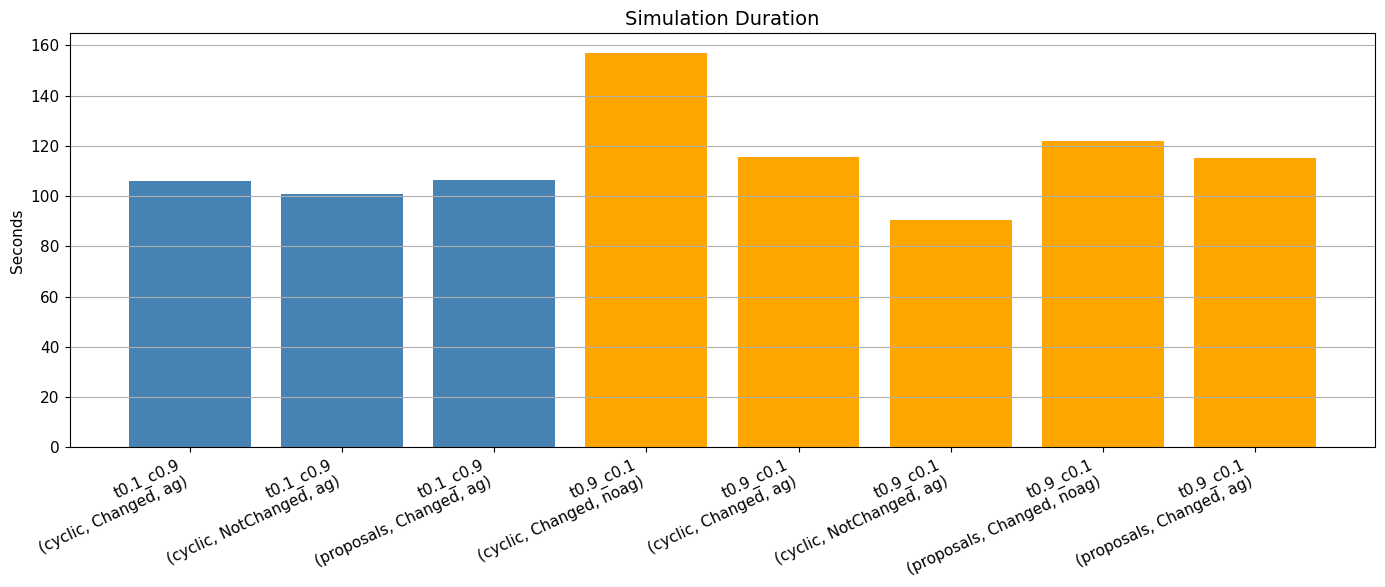

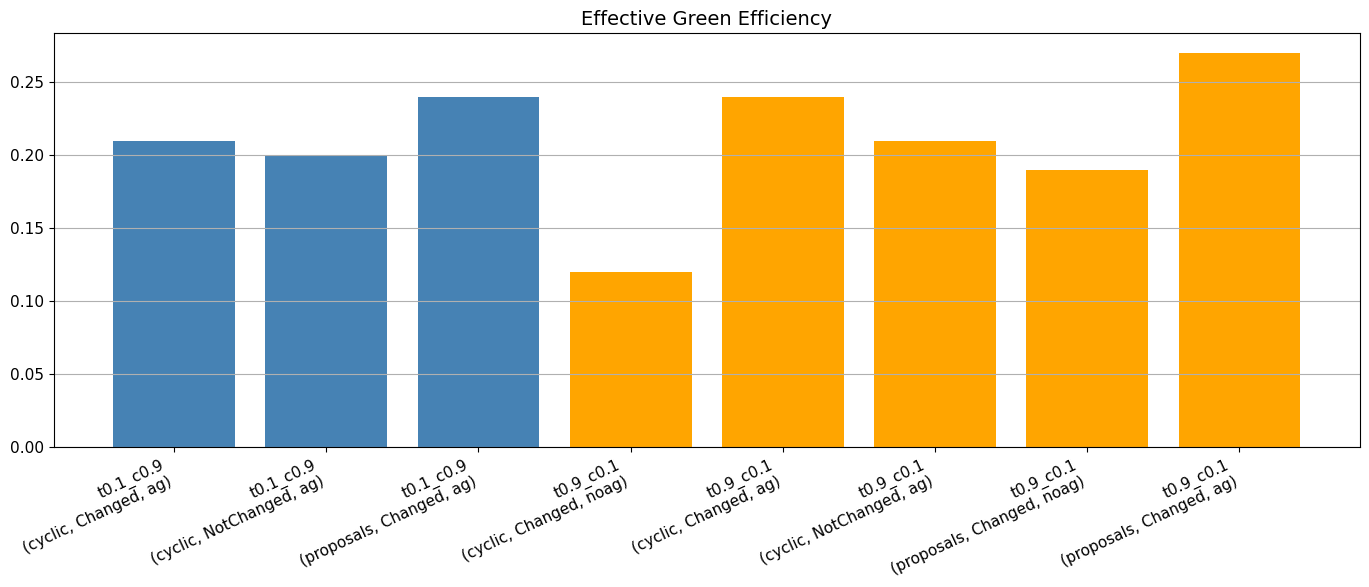

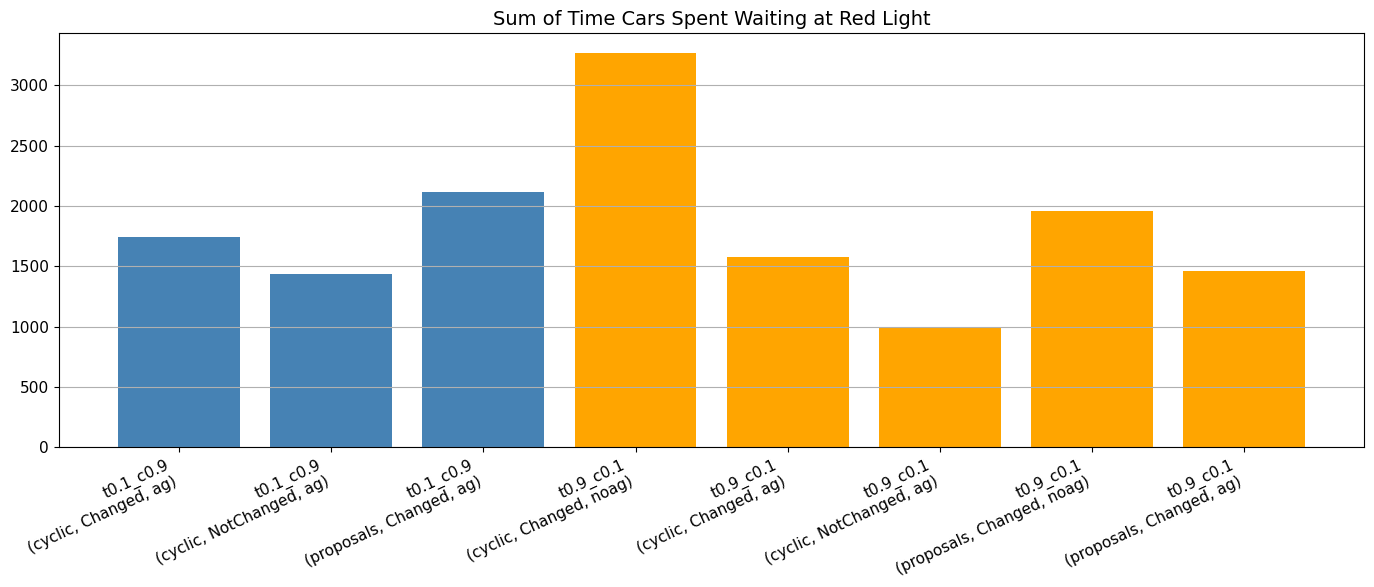

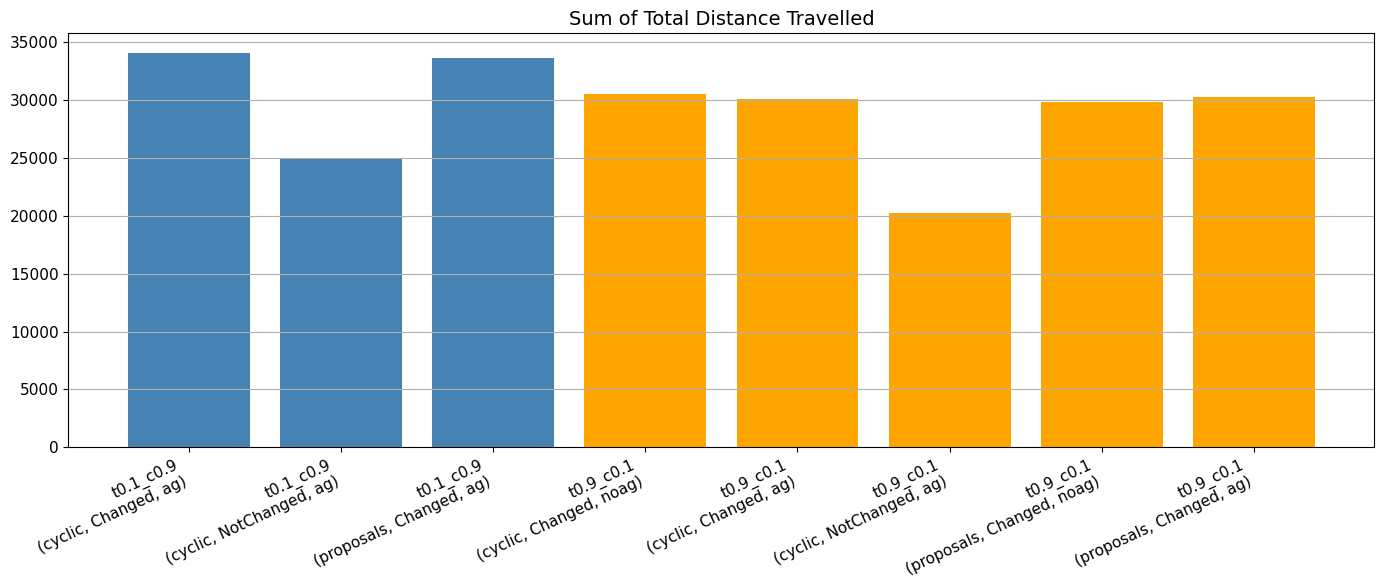

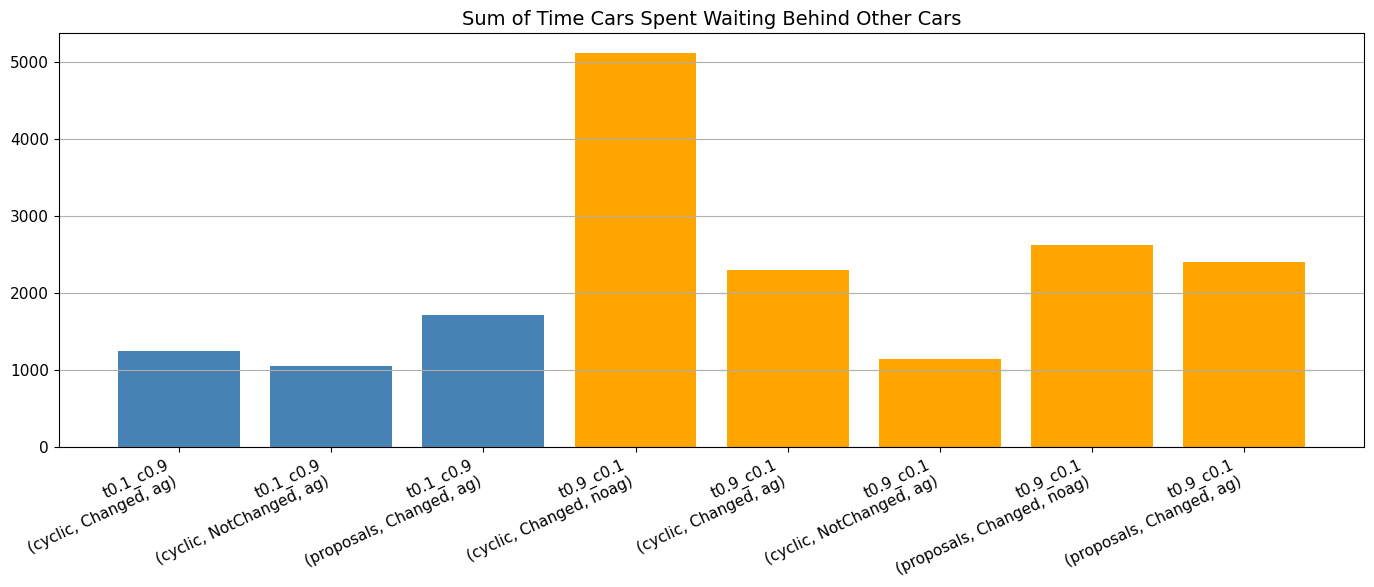

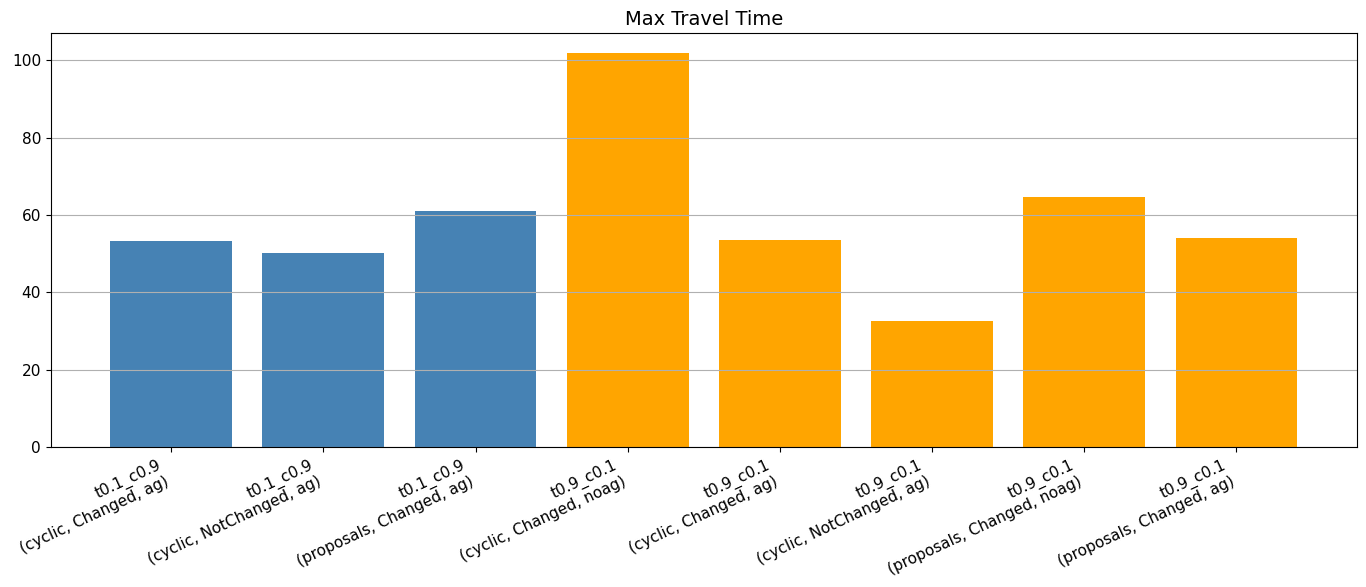

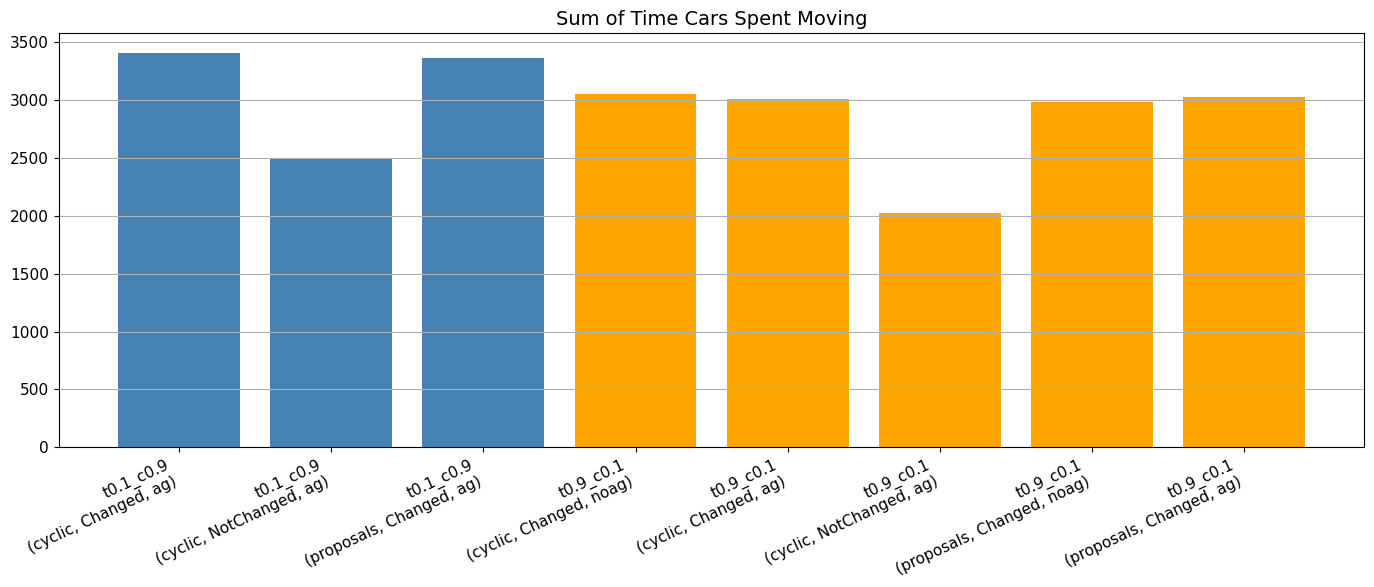

In [33]:
def get_nested(d, path):
    for p in path:
        d = d[p]
    return d

metric_paths = {
    "Simulation Duration": ["total_simulation_duration"],
    "Effective Green Efficiency": ["traffic_light_summary", "global_green_light_utilization"],
    "Sum of Time Cars Spent Waiting at Red Light": ["traffic_light_summary", "sum_tolerance_built_up"],
    "Sum of Total Distance Travelled": ["car_summary", "sum_total_distance"],
    "Sum of Time Cars Spent Waiting Behind Other Cars": ["car_summary", "sum_waiting_behind_cars"],
    "Max Travel Time": ["car_summary", "max_travel_time"],
    "Sum of Time Cars Spent Moving": ["car_summary", "sum_free_flow_time"],
}

metrics = {}

for metric_name, path in metric_paths.items():
    metrics[metric_name] = [
        get_nested(entry["data"], path)
        for entry in summary_list
    ]

labels = [entry["label"] for entry in summary_list]

for metric, values in metrics.items():

    # Color rule: t0.9 → orange, t0.1 → steelblue
    colors = [
        "orange" if "t0.9" in label else "steelblue"
        for label in labels
    ]

    plt.figure(figsize=(14, 6))
    plt.bar(labels, values, color=colors)

    plt.title(metric, fontsize=14)
    if metric == "Simulation Duration":
        plt.ylabel("Seconds")

    plt.xticks(rotation=25, ha='right')
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()